In [1]:
# Preliminary data notebook for
# NIH: Imaging Guided Intervention Surgery Study Section

# Exploratory aim: evaluate presurgical scans between STN and GPi targets
#   Given retrospective GPi acquisitions?
#   Search for radiomic differentiators for STN versus GPi selection in presurgical scans

In [2]:
# Import libraries
from datetime import date, datetime
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score
import SimpleITK as sitk
import six
from radiomics import featureextractor 
import numpy as np
import scipy.stats as stats
import os
import pickle

%matplotlib widget

In [3]:
# Set window level
level = 0
window = 500
m1=level-window/2
m2=level+window/2

load_data = 0
rextract = 0
retrain = 1
# Load data
# fig,ax = plt.subplots(2,5)
segs = []
qsms = []
voxel_sizes = []
trackers = []
directory = 'F:\dbs\stn-dbs\Cornell_anonymized'
case_list = []
if load_data == 1:
    for filename in os.listdir(directory):
        f = os.path.join(directory,filename)
        print(f)
    
        seg = nib.load(f+'/Rh Mri Brain With Without Contrast/seg.nii.gz')
                    
        voxel_size = seg.header['pixdim'][0:3]
        voxel_sizes.append(voxel_size)
        segs.append(seg.get_fdata())

        qsm = nib.load(f+'/Rh Mri Brain With Without Contrast/qsm.nii.gz')
        qsms.append(qsm.get_fdata())
            
        case_list.append(filename)
        n_cases = len(segs)

        label_min = np.partition(np.unique(seg.get_fdata().ravel()),1)[1]
        label_max = np.amax(seg.get_fdata())

In [4]:
# Define feature extraction
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.enableAllFeatures()
extractor.enableAllImageTypes()

# Generate feature structure Phi from all ROIs and all cases
if rextract == 1:
    Phi = []

    # Training cases
    for i in range(n_cases):
        seg_sitk = sitk.GetImageFromArray(segs[i])
        seg_sitk.SetSpacing(voxel_sizes[i].tolist())
        qsm_sitk = sitk.GetImageFromArray(qsms[i])
        qsm_sitk.SetSpacing(voxel_sizes[i].tolist())
        for j in range(int(label_min),int(label_max+1)):
            featureVector = extractor.execute(qsm_sitk,seg_sitk,label=j)
            Phi.append(featureVector)
    # Save feature vector
    with open('../features/Phi_57','wb') as fp:  
        pickle.dump(Phi,fp)


In [5]:
with open('../features/Phi_57','rb') as fp:  
    Phi = pickle.load(fp)

In [6]:
%%html
   <style>
   .cell-output-ipywidget-background {
      background-color: transparent !important;
   }
   .jp-OutputArea-output {
      background-color: transparent;
   }  
   </style>
   

In [7]:
# BAI features
subject_id = np.array((1,2,5,6,8,9,10,11,12,13,14,16,20,24,25,26))
pre_bai_on = np.array((42,3,46,4,40,13,22,34,2,40,4,4,13,44,4,23))
pre_bai_off = np.array((47,2,63,13,22,18,27,27,12,29,6,0.1,28,46,2,23))
post_bai_on = np.array((35,1,13,4,1,12,21,9,2,59,3,2,17,39,4,19))
per_change = (pre_bai_on-post_bai_on)/pre_bai_on
lct_change = (pre_bai_off-pre_bai_on)/pre_bai_off

In [8]:
case_id = np.repeat(subject_id,2)

In [9]:
n_cases = subject_id.__len__()

In [10]:
ut = np.zeros((subject_id.__len__()))
for j in np.arange(1,np.max(subject_id)+1):
    if j in subject_id:
        # Extract numeric feature values
        n_ROIs = 2
        x_row = []
        x_row_t = []
        keys = []
        per_change_train = []
        for i in range(Phi.__len__()//2+1):
            if i in subject_id:
                for ii in range(0,n_ROIs-1):
                    featureVector = Phi[i+ii]
                    for key,value in six.iteritems(featureVector):
                        if 'diagnostic' in key:
                            next
                        else:
                            try:
                                x_row.append(value.ravel())
                            except:
                                x_row.append(value)
                            keys.append(key)
                    if ii == 0 and pre_bai_off[subject_id == i].__len__()>0:
                        x_row.append((pre_bai_off[subject_id == i]))
                        x_row.append(pre_bai_on[subject_id == i])
                        keys.append('pre_sas_off')
                        keys.append('pre_sas_on')
                        per_change_train.append(per_change[subject_id == i])
                        
        jj = int(np.where(subject_id==j)[0])
        X0 = np.array(x_row)
        X = X0.reshape((n_cases,int(len(X0)/(n_cases))))
        X0_t = X[jj,:]
       
        # Normalize testing and training cases together
        #   Set with_mean=False to preserve data sparsity
        #   And with_std=False 
        #   However,need a significant number of samples to do this
        scaler = MinMaxScaler()
        X_all = np.vstack((X,X0_t))
        X_all_t = scaler.fit_transform(X_all)
        X_t = X_all_t[X.shape[0]:,:]
        Xin = X_all_t[:X.shape[0]]



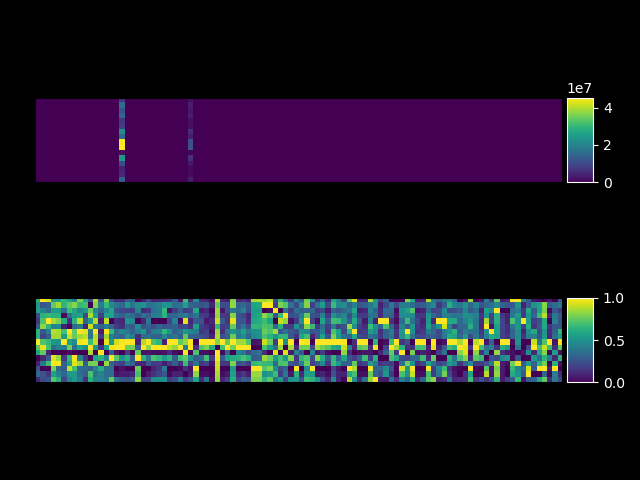

In [11]:
fig,ax = plt.subplots(2,1)
plt.style.use('dark_background')
im0 = ax[0].imshow(X[:,0:100])
im1 = ax[1].imshow(Xin[:,0:100])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xlabel('Feature index')
ax[0].set_ylabel('Case')
ax[1].set_ylabel('Case')
divider0 = make_axes_locatable(ax[0])
divider1 = make_axes_locatable(ax[1])
cax0 = divider0.append_axes('right',size='5%',pad=0.05)
fig.colorbar(im0,cax=cax0,orientation='vertical')
cax1 = divider1.append_axes('right',size='5%',pad=0.05)
fig.colorbar(im1,cax=cax1,orientation='vertical')
ax[1].set_title('Standardized feature matrix')
ax[0].set_title('Feature matrix $X$');
plt.tight_layout()



In [12]:
if retrain == 1:
    for j in np.arange(1,np.max(subject_id)+1):
        if j in subject_id:
            # Remove the test case
            jj = int(np.where(subject_id==j)[0])
            X_j = np.delete(Xin,jj,0)
            per_change_train_j = np.delete(per_change_train,jj,0)
            # Debug
            # print('Excluding subject',str(subject_id[jj]),'from training feature vector of shape',str(Xin.shape),'to create new training feature vector of shape',str(X_j.shape))
            if (sum(sum(np.isnan(X))))>0:
                print('NaN detected in feature vector')

            # Cross-validation for model selection
            cv = KFold(X_j.shape[0]-2)
            # Identify most important features
            # Do not assume data is centered,fit_intercept=True
            # Does LassoCV automatically do LOOCV?
            clf_in = LassoCV(fit_intercept=True,max_iter=10000,alphas=((1e-5,1e-4,1e-3,1e-2)),verbose=1,n_jobs=-1).fit(X_j,np.ravel(per_change_train_j))
            sfm = SelectFromModel(clf_in,max_features=100)
            # Initialize pipeline
            clf = Pipeline([('Lasso',sfm),('SVR',SVR(C=0,epsilon=0,kernel='rbf'))],verbose=1)
            # Select the optimal SVR parameters with grid search
            Cs = ((1e-2,1e-1,1))
            epsilons = ((0.1,0.2,0.25,0.5))
            
            clf_nsvr = GridSearchCV(clf,{'SVR__C':Cs,'SVR__epsilon':epsilons},n_jobs=-1,cv=cv,scoring='neg_mean_squared_error',error_score=0.0,verbose=1)
            clf_nsvr.fit(X_j,np.ravel(per_change_train_j))
            ut[jj] = clf_nsvr.best_estimator_.predict(Xin[jj,:].reshape(1,-1))
            print('Predicted percentage change of',ut[jj],'for case',subject_id[jj])
            print('True percentage change',per_change_train[jj])
            print(clf_in.alpha_)
            print(clf_nsvr.best_estimator_.get_params('SVR__epsilon'))
            print(clf_nsvr.best_estimator_.get_params('SVR__C'))



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
.................

Fitting 13 folds for each of 12 candidates, totalling 156 fits


...[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
....................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
...........

[Pipeline] ............. (step 1 of 2) Processing Lasso, total=   0.3s
[Pipeline] ............... (step 2 of 2) Processing SVR, total=   0.0s
Predicted percentage change of 0.15425779102631154 for case 1
True percentage change [0.16666667]
0.01
{'memory': None, 'steps': [('Lasso', SelectFromModel(estimator=LassoCV(alphas=(1e-05, 0.0001, 0.001, 0.01),
                                  max_iter=10000, n_jobs=-1, verbose=1),
                max_features=100)), ('SVR', SVR(C=0.01))], 'verbose': 1, 'Lasso': SelectFromModel(estimator=LassoCV(alphas=(1e-05, 0.0001, 0.001, 0.01),
                                  max_iter=10000, n_jobs=-1, verbose=1),
                max_features=100), 'SVR': SVR(C=0.01), 'Lasso__estimator__alphas': (1e-05, 0.0001, 0.001, 0.01), 'Lasso__estimator__copy_X': True, 'Lasso__estimator__cv': None, 'Lasso__estimator__eps': 0.001, 'Lasso__estimator__fit_intercept': True, 'Lasso__estimator__max_iter': 10000, 'Lasso__estimator__n_alphas': 100, 'Lasso__estimator__n_jobs'

.........[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 13 folds for each of 12 candidates, totalling 156 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
....................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


[Pipeline] ............. (step 1 of 2) Processing Lasso, total=   0.3s
[Pipeline] ............... (step 2 of 2) Processing SVR, total=   0.0s
Predicted percentage change of 0.2050962508230809 for case 2
True percentage change [0.66666667]
0.01
{'memory': None, 'steps': [('Lasso', SelectFromModel(estimator=LassoCV(alphas=(1e-05, 0.0001, 0.001, 0.01),
                                  max_iter=10000, n_jobs=-1, verbose=1),
                max_features=100)), ('SVR', SVR(C=0.01, epsilon=0.2))], 'verbose': 1, 'Lasso': SelectFromModel(estimator=LassoCV(alphas=(1e-05, 0.0001, 0.001, 0.01),
                                  max_iter=10000, n_jobs=-1, verbose=1),
                max_features=100), 'SVR': SVR(C=0.01, epsilon=0.2), 'Lasso__estimator__alphas': (1e-05, 0.0001, 0.001, 0.01), 'Lasso__estimator__copy_X': True, 'Lasso__estimator__cv': None, 'Lasso__estimator__eps': 0.001, 'Lasso__estimator__fit_intercept': True, 'Lasso__estimator__max_iter': 10000, 'Lasso__estimator__n_alphas': 100, '

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
....................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 13 folds for each of 12 candidates, totalling 156 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
....................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.


[Pipeline] ............. (step 1 of 2) Processing Lasso, total=   0.3s
[Pipeline] ............... (step 2 of 2) Processing SVR, total=   0.0s
Predicted percentage change of 0.20339534435547862 for case 5
True percentage change [0.7173913]
0.01
{'memory': None, 'steps': [('Lasso', SelectFromModel(estimator=LassoCV(alphas=(1e-05, 0.0001, 0.001, 0.01),
                                  max_iter=10000, n_jobs=-1, verbose=1),
                max_features=100)), ('SVR', SVR(C=0.01, epsilon=0.2))], 'verbose': 1, 'Lasso': SelectFromModel(estimator=LassoCV(alphas=(1e-05, 0.0001, 0.001, 0.01),
                                  max_iter=10000, n_jobs=-1, verbose=1),
                max_features=100), 'SVR': SVR(C=0.01, epsilon=0.2), 'Lasso__estimator__alphas': (1e-05, 0.0001, 0.001, 0.01), 'Lasso__estimator__copy_X': True, 'Lasso__estimator__cv': None, 'Lasso__estimator__eps': 0.001, 'Lasso__estimator__fit_intercept': True, 'Lasso__estimator__max_iter': 10000, 'Lasso__estimator__n_alphas': 100, '

....................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 13 folds for each of 12 candidates, totalling 156 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
....................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.


[Pipeline] ............. (step 1 of 2) Processing Lasso, total=   0.7s
[Pipeline] ............... (step 2 of 2) Processing SVR, total=   0.0s
Predicted percentage change of 0.16832976514882708 for case 6
True percentage change [0.]
0.01
{'memory': None, 'steps': [('Lasso', SelectFromModel(estimator=LassoCV(alphas=(1e-05, 0.0001, 0.001, 0.01),
                                  max_iter=10000, n_jobs=-1, verbose=1),
                max_features=100)), ('SVR', SVR(C=0.01))], 'verbose': 1, 'Lasso': SelectFromModel(estimator=LassoCV(alphas=(1e-05, 0.0001, 0.001, 0.01),
                                  max_iter=10000, n_jobs=-1, verbose=1),
                max_features=100), 'SVR': SVR(C=0.01), 'Lasso__estimator__alphas': (1e-05, 0.0001, 0.001, 0.01), 'Lasso__estimator__copy_X': True, 'Lasso__estimator__cv': None, 'Lasso__estimator__eps': 0.001, 'Lasso__estimator__fit_intercept': True, 'Lasso__estimator__max_iter': 10000, 'Lasso__estimator__n_alphas': 100, 'Lasso__estimator__n_jobs': -1, 'L

....................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 13 folds for each of 12 candidates, totalling 156 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
....................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


[Pipeline] ............. (step 1 of 2) Processing Lasso, total=   0.3s
[Pipeline] ............... (step 2 of 2) Processing SVR, total=   0.0s
Predicted percentage change of 0.1517468114760983 for case 8
True percentage change [0.975]
0.01
{'memory': None, 'steps': [('Lasso', SelectFromModel(estimator=LassoCV(alphas=(1e-05, 0.0001, 0.001, 0.01),
                                  max_iter=10000, n_jobs=-1, verbose=1),
                max_features=100)), ('SVR', SVR(C=0.1, epsilon=0.5))], 'verbose': 1, 'Lasso': SelectFromModel(estimator=LassoCV(alphas=(1e-05, 0.0001, 0.001, 0.01),
                                  max_iter=10000, n_jobs=-1, verbose=1),
                max_features=100), 'SVR': SVR(C=0.1, epsilon=0.5), 'Lasso__estimator__alphas': (1e-05, 0.0001, 0.001, 0.01), 'Lasso__estimator__copy_X': True, 'Lasso__estimator__cv': None, 'Lasso__estimator__eps': 0.001, 'Lasso__estimator__fit_intercept': True, 'Lasso__estimator__max_iter': 10000, 'Lasso__estimator__n_alphas': 100, 'Lasso__

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
....................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 13 folds for each of 12 candidates, totalling 156 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
....................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


[Pipeline] ............. (step 1 of 2) Processing Lasso, total=   0.3s
[Pipeline] ............... (step 2 of 2) Processing SVR, total=   0.0s
Predicted percentage change of 0.2583848544899268 for case 9
True percentage change [0.07692308]
0.01
{'memory': None, 'steps': [('Lasso', SelectFromModel(estimator=LassoCV(alphas=(1e-05, 0.0001, 0.001, 0.01),
                                  max_iter=10000, n_jobs=-1, verbose=1),
                max_features=100)), ('SVR', SVR(C=0.01, epsilon=0.25))], 'verbose': 1, 'Lasso': SelectFromModel(estimator=LassoCV(alphas=(1e-05, 0.0001, 0.001, 0.01),
                                  max_iter=10000, n_jobs=-1, verbose=1),
                max_features=100), 'SVR': SVR(C=0.01, epsilon=0.25), 'Lasso__estimator__alphas': (1e-05, 0.0001, 0.001, 0.01), 'Lasso__estimator__copy_X': True, 'Lasso__estimator__cv': None, 'Lasso__estimator__eps': 0.001, 'Lasso__estimator__fit_intercept': True, 'Lasso__estimator__max_iter': 10000, 'Lasso__estimator__n_alphas': 100,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
....................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 13 folds for each of 12 candidates, totalling 156 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
....................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.


[Pipeline] ............. (step 1 of 2) Processing Lasso, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing SVR, total=   0.0s
Predicted percentage change of 0.2629079470048715 for case 10
True percentage change [0.04545455]
0.01
{'memory': None, 'steps': [('Lasso', SelectFromModel(estimator=LassoCV(alphas=(1e-05, 0.0001, 0.001, 0.01),
                                  max_iter=10000, n_jobs=-1, verbose=1),
                max_features=100)), ('SVR', SVR(C=0.01, epsilon=0.25))], 'verbose': 1, 'Lasso': SelectFromModel(estimator=LassoCV(alphas=(1e-05, 0.0001, 0.001, 0.01),
                                  max_iter=10000, n_jobs=-1, verbose=1),
                max_features=100), 'SVR': SVR(C=0.01, epsilon=0.25), 'Lasso__estimator__alphas': (1e-05, 0.0001, 0.001, 0.01), 'Lasso__estimator__copy_X': True, 'Lasso__estimator__cv': None, 'Lasso__estimator__eps': 0.001, 'Lasso__estimator__fit_intercept': True, 'Lasso__estimator__max_iter': 10000, 'Lasso__estimator__n_alphas': 100

....................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 13 folds for each of 12 candidates, totalling 156 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
....................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
.....

[Pipeline] ............. (step 1 of 2) Processing Lasso, total=   0.6s
[Pipeline] ............... (step 2 of 2) Processing SVR, total=   0.0s
Predicted percentage change of 0.20678068916030737 for case 11
True percentage change [0.73529412]
0.01
{'memory': None, 'steps': [('Lasso', SelectFromModel(estimator=LassoCV(alphas=(1e-05, 0.0001, 0.001, 0.01),
                                  max_iter=10000, n_jobs=-1, verbose=1),
                max_features=100)), ('SVR', SVR(C=0.01, epsilon=0.2))], 'verbose': 1, 'Lasso': SelectFromModel(estimator=LassoCV(alphas=(1e-05, 0.0001, 0.001, 0.01),
                                  max_iter=10000, n_jobs=-1, verbose=1),
                max_features=100), 'SVR': SVR(C=0.01, epsilon=0.2), 'Lasso__estimator__alphas': (1e-05, 0.0001, 0.001, 0.01), 'Lasso__estimator__copy_X': True, 'Lasso__estimator__cv': None, 'Lasso__estimator__eps': 0.001, 'Lasso__estimator__fit_intercept': True, 'Lasso__estimator__max_iter': 10000, 'Lasso__estimator__n_alphas': 100,

...............[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 13 folds for each of 12 candidates, totalling 156 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
....................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


[Pipeline] ............. (step 1 of 2) Processing Lasso, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing SVR, total=   0.0s
Predicted percentage change of 0.16834874940712952 for case 12
True percentage change [0.]
0.01
{'memory': None, 'steps': [('Lasso', SelectFromModel(estimator=LassoCV(alphas=(1e-05, 0.0001, 0.001, 0.01),
                                  max_iter=10000, n_jobs=-1, verbose=1),
                max_features=100)), ('SVR', SVR(C=0.01))], 'verbose': 1, 'Lasso': SelectFromModel(estimator=LassoCV(alphas=(1e-05, 0.0001, 0.001, 0.01),
                                  max_iter=10000, n_jobs=-1, verbose=1),
                max_features=100), 'SVR': SVR(C=0.01), 'Lasso__estimator__alphas': (1e-05, 0.0001, 0.001, 0.01), 'Lasso__estimator__copy_X': True, 'Lasso__estimator__cv': None, 'Lasso__estimator__eps': 0.001, 'Lasso__estimator__fit_intercept': True, 'Lasso__estimator__max_iter': 10000, 'Lasso__estimator__n_alphas': 100, 'Lasso__estimator__n_jobs': -1, '

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
....................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 13 folds for each of 12 candidates, totalling 156 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
....................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


[Pipeline] ............. (step 1 of 2) Processing Lasso, total=   0.6s
[Pipeline] ............... (step 2 of 2) Processing SVR, total=   0.0s
Predicted percentage change of 0.28447679421335165 for case 13
True percentage change [-0.475]
0.01
{'memory': None, 'steps': [('Lasso', SelectFromModel(estimator=LassoCV(alphas=(1e-05, 0.0001, 0.001, 0.01),
                                  max_iter=10000, n_jobs=-1, verbose=1),
                max_features=100)), ('SVR', SVR(C=0.01, epsilon=0.25))], 'verbose': 1, 'Lasso': SelectFromModel(estimator=LassoCV(alphas=(1e-05, 0.0001, 0.001, 0.01),
                                  max_iter=10000, n_jobs=-1, verbose=1),
                max_features=100), 'SVR': SVR(C=0.01, epsilon=0.25), 'Lasso__estimator__alphas': (1e-05, 0.0001, 0.001, 0.01), 'Lasso__estimator__copy_X': True, 'Lasso__estimator__cv': None, 'Lasso__estimator__eps': 0.001, 'Lasso__estimator__fit_intercept': True, 'Lasso__estimator__max_iter': 10000, 'Lasso__estimator__n_alphas': 100, '

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
....................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 13 folds for each of 12 candidates, totalling 156 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
....................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


[Pipeline] ............. (step 1 of 2) Processing Lasso, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing SVR, total=   0.0s
Predicted percentage change of 0.26124730262125995 for case 14
True percentage change [0.25]
0.01
{'memory': None, 'steps': [('Lasso', SelectFromModel(estimator=LassoCV(alphas=(1e-05, 0.0001, 0.001, 0.01),
                                  max_iter=10000, n_jobs=-1, verbose=1),
                max_features=100)), ('SVR', SVR(C=0.01, epsilon=0.25))], 'verbose': 1, 'Lasso': SelectFromModel(estimator=LassoCV(alphas=(1e-05, 0.0001, 0.001, 0.01),
                                  max_iter=10000, n_jobs=-1, verbose=1),
                max_features=100), 'SVR': SVR(C=0.01, epsilon=0.25), 'Lasso__estimator__alphas': (1e-05, 0.0001, 0.001, 0.01), 'Lasso__estimator__copy_X': True, 'Lasso__estimator__cv': None, 'Lasso__estimator__eps': 0.001, 'Lasso__estimator__fit_intercept': True, 'Lasso__estimator__max_iter': 10000, 'Lasso__estimator__n_alphas': 100, 'La

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
....................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 13 folds for each of 12 candidates, totalling 156 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
....................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
..

[Pipeline] ............. (step 1 of 2) Processing Lasso, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing SVR, total=   0.0s
Predicted percentage change of 0.20898016670683678 for case 16
True percentage change [0.5]
0.01
{'memory': None, 'steps': [('Lasso', SelectFromModel(estimator=LassoCV(alphas=(1e-05, 0.0001, 0.001, 0.01),
                                  max_iter=10000, n_jobs=-1, verbose=1),
                max_features=100)), ('SVR', SVR(C=0.01, epsilon=0.2))], 'verbose': 1, 'Lasso': SelectFromModel(estimator=LassoCV(alphas=(1e-05, 0.0001, 0.001, 0.01),
                                  max_iter=10000, n_jobs=-1, verbose=1),
                max_features=100), 'SVR': SVR(C=0.01, epsilon=0.2), 'Lasso__estimator__alphas': (1e-05, 0.0001, 0.001, 0.01), 'Lasso__estimator__copy_X': True, 'Lasso__estimator__cv': None, 'Lasso__estimator__eps': 0.001, 'Lasso__estimator__fit_intercept': True, 'Lasso__estimator__max_iter': 10000, 'Lasso__estimator__n_alphas': 100, 'Lasso

..................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 13 folds for each of 12 candidates, totalling 156 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
....................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


[Pipeline] ............. (step 1 of 2) Processing Lasso, total=   0.6s
[Pipeline] ............... (step 2 of 2) Processing SVR, total=   0.0s
Predicted percentage change of 0.2851373232146195 for case 20
True percentage change [-0.30769231]
0.01
{'memory': None, 'steps': [('Lasso', SelectFromModel(estimator=LassoCV(alphas=(1e-05, 0.0001, 0.001, 0.01),
                                  max_iter=10000, n_jobs=-1, verbose=1),
                max_features=100)), ('SVR', SVR(C=0.01, epsilon=0.25))], 'verbose': 1, 'Lasso': SelectFromModel(estimator=LassoCV(alphas=(1e-05, 0.0001, 0.001, 0.01),
                                  max_iter=10000, n_jobs=-1, verbose=1),
                max_features=100), 'SVR': SVR(C=0.01, epsilon=0.25), 'Lasso__estimator__alphas': (1e-05, 0.0001, 0.001, 0.01), 'Lasso__estimator__copy_X': True, 'Lasso__estimator__cv': None, 'Lasso__estimator__eps': 0.001, 'Lasso__estimator__fit_intercept': True, 'Lasso__estimator__max_iter': 10000, 'Lasso__estimator__n_alphas': 10

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
....................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 13 folds for each of 12 candidates, totalling 156 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
....................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


[Pipeline] ............. (step 1 of 2) Processing Lasso, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing SVR, total=   0.0s
Predicted percentage change of 0.27398316584185567 for case 24
True percentage change [0.11363636]
0.01
{'memory': None, 'steps': [('Lasso', SelectFromModel(estimator=LassoCV(alphas=(1e-05, 0.0001, 0.001, 0.01),
                                  max_iter=10000, n_jobs=-1, verbose=1),
                max_features=100)), ('SVR', SVR(C=0.01, epsilon=0.25))], 'verbose': 1, 'Lasso': SelectFromModel(estimator=LassoCV(alphas=(1e-05, 0.0001, 0.001, 0.01),
                                  max_iter=10000, n_jobs=-1, verbose=1),
                max_features=100), 'SVR': SVR(C=0.01, epsilon=0.25), 'Lasso__estimator__alphas': (1e-05, 0.0001, 0.001, 0.01), 'Lasso__estimator__copy_X': True, 'Lasso__estimator__cv': None, 'Lasso__estimator__eps': 0.001, 'Lasso__estimator__fit_intercept': True, 'Lasso__estimator__max_iter': 10000, 'Lasso__estimator__n_alphas': 10

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
....................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 13 folds for each of 12 candidates, totalling 156 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
....................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.


[Pipeline] ............. (step 1 of 2) Processing Lasso, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing SVR, total=   0.0s
Predicted percentage change of 0.28065217626938643 for case 25
True percentage change [0.]
0.01
{'memory': None, 'steps': [('Lasso', SelectFromModel(estimator=LassoCV(alphas=(1e-05, 0.0001, 0.001, 0.01),
                                  max_iter=10000, n_jobs=-1, verbose=1),
                max_features=100)), ('SVR', SVR(C=0.01, epsilon=0.25))], 'verbose': 1, 'Lasso': SelectFromModel(estimator=LassoCV(alphas=(1e-05, 0.0001, 0.001, 0.01),
                                  max_iter=10000, n_jobs=-1, verbose=1),
                max_features=100), 'SVR': SVR(C=0.01, epsilon=0.25), 'Lasso__estimator__alphas': (1e-05, 0.0001, 0.001, 0.01), 'Lasso__estimator__copy_X': True, 'Lasso__estimator__cv': None, 'Lasso__estimator__eps': 0.001, 'Lasso__estimator__fit_intercept': True, 'Lasso__estimator__max_iter': 10000, 'Lasso__estimator__n_alphas': 100, 'Lass

....................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 13 folds for each of 12 candidates, totalling 156 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
..............

[Pipeline] ............. (step 1 of 2) Processing Lasso, total=   0.5s
[Pipeline] ............... (step 2 of 2) Processing SVR, total=   0.0s
Predicted percentage change of 0.24914439157331023 for case 26
True percentage change [0.17391304]
0.01
{'memory': None, 'steps': [('Lasso', SelectFromModel(estimator=LassoCV(alphas=(1e-05, 0.0001, 0.001, 0.01),
                                  max_iter=10000, n_jobs=-1, verbose=1),
                max_features=100)), ('SVR', SVR(C=0.01, epsilon=0.25))], 'verbose': 1, 'Lasso': SelectFromModel(estimator=LassoCV(alphas=(1e-05, 0.0001, 0.001, 0.01),
                                  max_iter=10000, n_jobs=-1, verbose=1),
                max_features=100), 'SVR': SVR(C=0.01, epsilon=0.25), 'Lasso__estimator__alphas': (1e-05, 0.0001, 0.001, 0.01), 'Lasso__estimator__copy_X': True, 'Lasso__estimator__cv': None, 'Lasso__estimator__eps': 0.001, 'Lasso__estimator__fit_intercept': True, 'Lasso__estimator__max_iter': 10000, 'Lasso__estimator__n_alphas': 10

......[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


In [24]:
if retrain == 1:
    for j in np.arange(1,np.max(subject_id)+1):
        if j in subject_id:
            # Remove the test case
            jj = int(np.where(subject_id==j)[0])
            X_j = np.delete(Xin,jj,0)
            per_change_train_j = np.delete(per_change_train,jj,0)
            # Debug
            # print('Excluding subject',str(subject_id[jj]),'from training feature vector of shape',str(Xin.shape),'to create new training feature vector of shape',str(X_j.shape))
            if (sum(sum(np.isnan(X))))>0:
                print('NaN detected in feature vector')

            # Cross-validation for model selection
            cv = KFold(X_j.shape[0]-2)
            # Identify most important features
            # Do not assume data is centered,fit_intercept=True
            # Does LassoCV automatically do LOOCV?
            clf_in = Lasso(fit_intercept=True,max_iter=10000,alpha=((1e-3))).fit(X_j,np.ravel(per_change_train_j))
            sfm = SelectFromModel(clf_in,max_features=100)
            # Initialize pipeline
            clf = Pipeline([('Lasso',sfm),('SVR',SVR(C=0,epsilon=0,kernel='rbf'))],verbose=1)
            # Select the optimal SVR parameters with grid search
            Cs = [0.01]
            epsilons = [0.25]
            
            clf_nsvr = GridSearchCV(clf,{'SVR__C':Cs,'SVR__epsilon':epsilons},n_jobs=-1,cv=cv,scoring='neg_mean_squared_error',error_score=0.0,verbose=1)
            clf_nsvr.fit(X_j,np.ravel(per_change_train_j))
            ut[jj] = clf_nsvr.best_estimator_.predict(Xin[jj,:].reshape(1,-1))
            print('Predicted percentage change of',ut[jj],'for case',subject_id[jj])
            print('True percentage change',per_change_train[jj])


Fitting 13 folds for each of 1 candidates, totalling 13 fits
[Pipeline] ............. (step 1 of 2) Processing Lasso, total=   0.3s
[Pipeline] ............... (step 2 of 2) Processing SVR, total=   0.0s
Predicted percentage change of 0.2577107548143508 for case 1
True percentage change [0.16666667]
Fitting 13 folds for each of 1 candidates, totalling 13 fits
[Pipeline] ............. (step 1 of 2) Processing Lasso, total=   0.2s
[Pipeline] ............... (step 2 of 2) Processing SVR, total=   0.0s
Predicted percentage change of 0.2523131462262573 for case 2
True percentage change [0.66666667]
Fitting 13 folds for each of 1 candidates, totalling 13 fits
[Pipeline] ............. (step 1 of 2) Processing Lasso, total=   0.2s
[Pipeline] ............... (step 2 of 2) Processing SVR, total=   0.0s
Predicted percentage change of 0.2539469969527372 for case 5
True percentage change [0.7173913]
Fitting 13 folds for each of 1 candidates, totalling 13 fits
[Pipeline] ............. (step 1 of 2) P

In [25]:
clf_nsvr.best_estimator_.steps[0][1].estimator

Lasso(alpha=0.001, max_iter=10000)

In [26]:
if retrain == 1:
    with open('lasso_sas_pred.npy','wb') as f:
        np.save(f,ut)
else:
    with open('lasso_sas_pred.npy','rb') as f:
        ut = np.load(f)

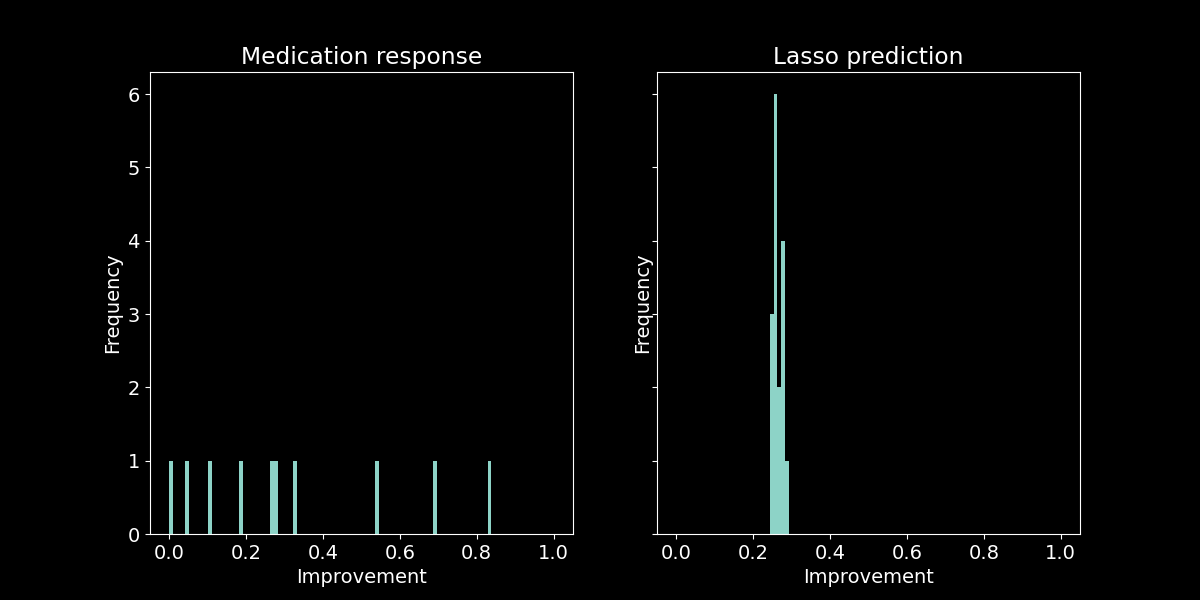

In [27]:
[fig,ax] = plt.subplots(1,2,sharex=True,sharey=True)
ax[0].hist([lct_change],bins=np.linspace(0,1,100))
ax[0].set_title('Medication response')
ax[0].set_xlabel('Improvement')
ax[0].set_ylabel('Frequency')
ax[1].hist([ut],bins=np.linspace(0,1,100))
ax[1].set_title('Lasso prediction')
ax[1].set_xlabel('Improvement')
ax[1].set_ylabel('Frequency')
fig.set_size_inches(12,6)

/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Text(0.5, 0.98, 'BAI-II Improvement')

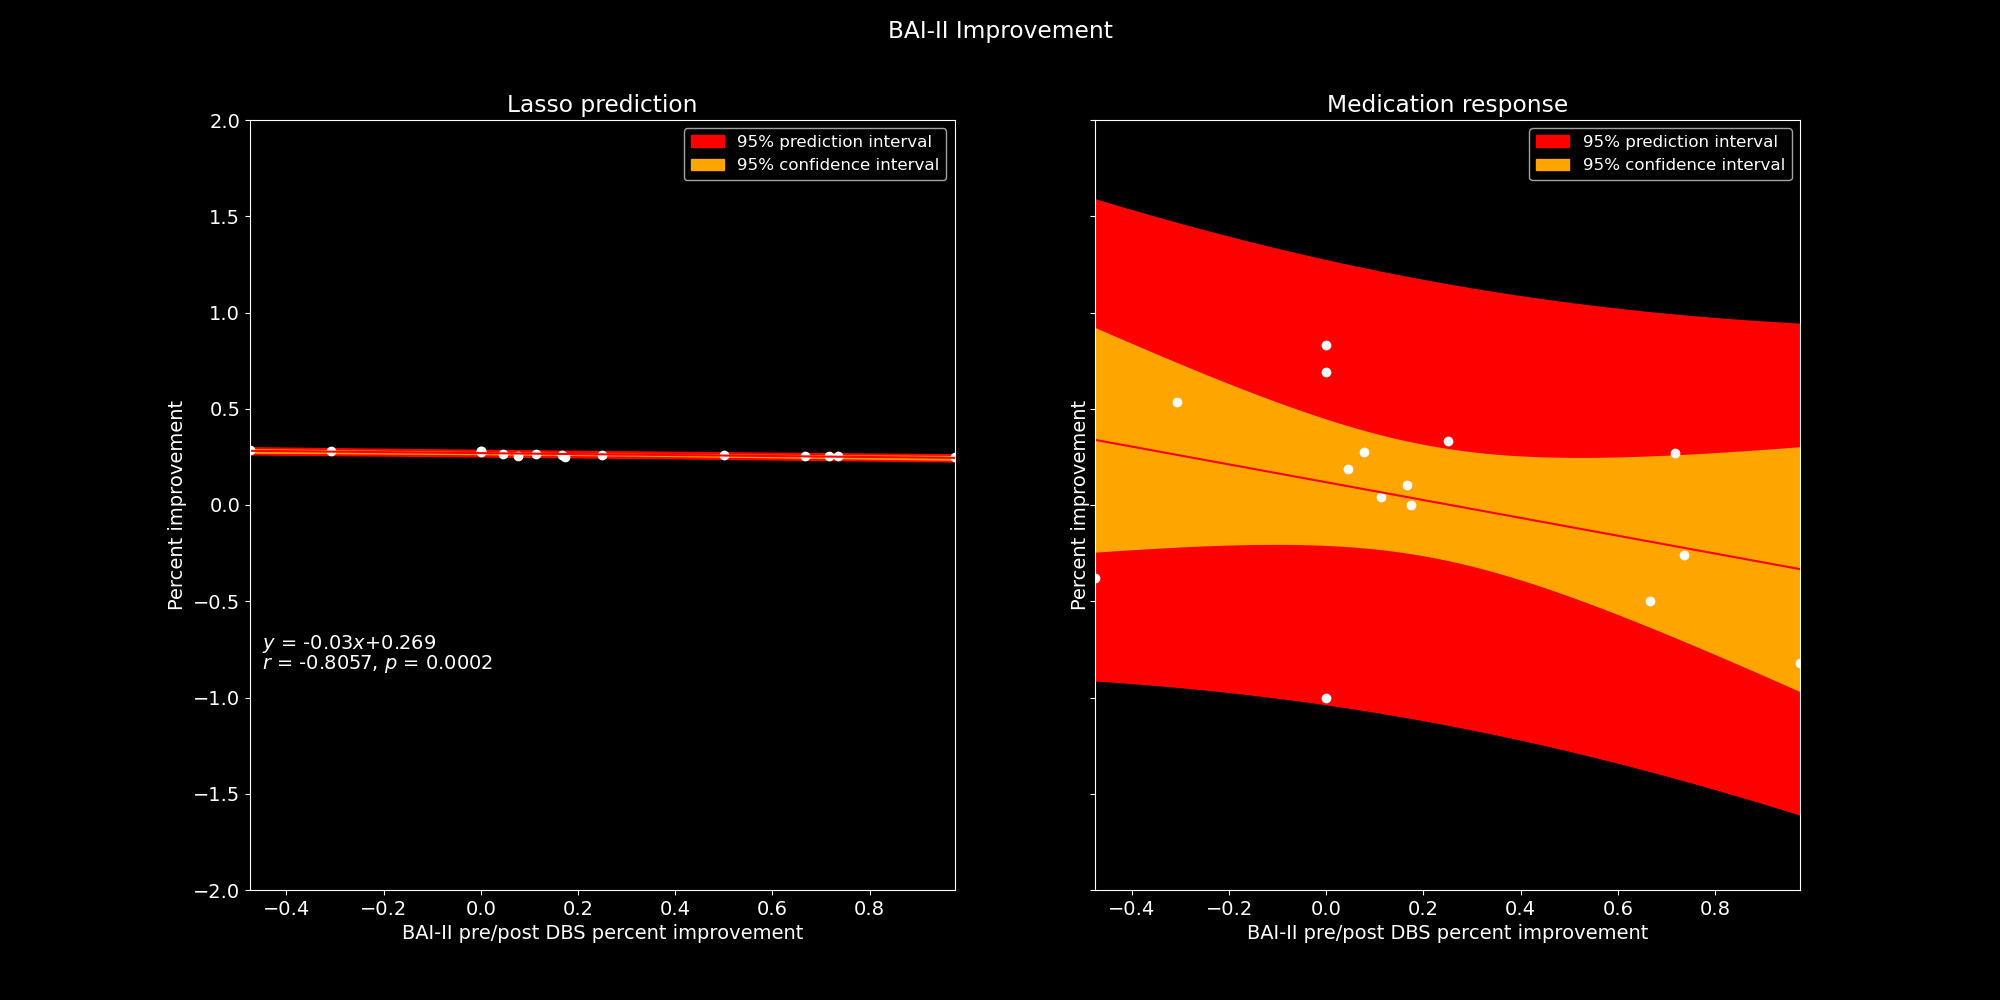

In [37]:
x = per_change
y = ut

slope,intercept = np.polyfit(x,y,1)  # linear model adjustment
y_model = np.polyval([slope,intercept],x)   # modeling...

x_mean = np.mean(x)
y_mean = np.mean(y)
n = x.size                        # number of samples
m = 2                             # number of parameters
dof = n-m                       # degrees of freedom
t = stats.t.ppf(0.975,dof)       # Students statistic of interval confidence
residual_ut = y-y_model

std_error = (np.sum(residual_ut**2)/dof)**(1/2)   # Standard deviation of the error

# Pearson's correlation coefficient
numerator = np.sum((x-x_mean)*(y-y_mean))
denominator = (np.sum((x-x_mean)**2)*np.sum((y-y_mean)**2))**.5
correlation_coef = numerator/denominator
r = correlation_coef
tr = r*np.sqrt(n-2)/(np.sqrt(1-r**2))
# p-value for 2-sided test
pv = 2*(1-stats.t.cdf(abs(tr), dof))
# # mean squared error
MSE = 1/n*np.sum((y-y_model)**2)

# to plot the adjusted model
x_line = np.linspace(np.min(x),np.max(x),100)
y_line = np.polyval([slope,intercept],x_line)

# confidence interval
ci = t*std_error*(1/n+(x_line-x_mean)**2/np.sum((x-x_mean)**2))**.5
# predicting interval
pi = t*std_error*(1+1/n+(x_line-x_mean)**2/np.sum((x-x_mean)**2))**.5  


plt.rcParams.update({'font.size': 14})
[fig,ax] = plt.subplots(1,2,sharex=True,sharey=True)

ax[0].plot(x,y,'o',color = 'white')
ax[0].plot(x_line,y_line,color = 'red')
ax[0].fill_between(x_line,y_line+pi,y_line-pi,color = 'red',label = '95% prediction interval')
ax[0].fill_between(x_line,y_line+ci,y_line-ci,color = 'orange',label = '95% confidence interval')

ax[0].set_xlabel('BAI-II pre/post DBS percent improvement')
ax[0].set_ylabel('Percent improvement')
ax[0].set_ylim([-2,2])
ax[0].set_title('Lasso prediction')

ax[0].text(-0.45,-0.75,'$y$ = '+ str(np.round(slope,2))+'$x$'+'+'+str(np.round(intercept,3)),color='w')
ax[0].text(-0.45,-0.85,'$r$ = '+str(np.round(r,4))+', $p$ = '+str(round(pv,4)),color='w')
ax[0].margins(x=0)
fig.set_size_inches(20,10)
ax[0].legend(bbox_to_anchor=(1,1),fontsize=12)



## Medication response
x = per_change
x = per_change[lct_change<2]
x = per_change[lct_change>-2]
y = lct_change
y = lct_change[lct_change<2]
y = lct_change[lct_change>-2]

# Fit and evaluate linear model
slope,intercept = np.polyfit(x,y,1)
y_model = np.polyval([slope,intercept],x)   

# Prepare correlation stats
x_mean = np.mean(x)
y_mean = np.mean(y)
# Sample size
n = x.size         
# Parameters assuming a normal distribution              
m = 2
# Degrees of freedom                            
dof = n-m
# Students statistic of interval confidence                      
t = stats.t.ppf(0.975,dof)      
pv = r*np.sqrt(n-2)/(np.sqrt(1-r**2))
# Standard deviation of the error
residual_lct = y-y_model
std_error = (np.sum(residual_lct**2)/dof)**(1/2)   

# Pearson's correlation coefficient
numerator = np.sum((x-x_mean)*(y-y_mean))
denominator = (np.sum((x-x_mean)**2)*np.sum((y-y_mean)**2))**.5
correlation_coef = numerator/denominator
r = correlation_coef
tr = r*np.sqrt(n-2)/(np.sqrt(1-r**2))
# p-value for 2-sided test
pv = 2*(1-stats.t.cdf(abs(tr), dof))

# mean squared error
MSE = 1/n*np.sum((y-y_model)**2)

# to plot the adjusted model
x_line = np.linspace(np.min(x),np.max(x),100)
y_line = np.polyval([slope,intercept],x_line)

# confidence interval
ci = t*std_error*(1/n+(x_line-x_mean)**2/np.sum((x-x_mean)**2))**.5
# predicting interval
pi = t*std_error*(1+1/n+(x_line-x_mean)**2/np.sum((x-x_mean)**2))**.5  


ax[1].plot(x,y,'o',color = 'white')
ax[1].plot(x_line,y_line,color = 'red')
ax[1].fill_between(x_line,y_line+pi,y_line-pi,color = 'red',label = '95% prediction interval')
ax[1].fill_between(x_line,y_line+ci,y_line-ci,color = 'orange',label = '95% confidence interval')

ax[1].set_xlabel('BAI-II pre/post DBS percent improvement')
ax[1].set_ylabel('Percent improvement')
ax[1].set_title('Medication response')


ax[1].text(-0.45,-36,'$y$ = '+ str(np.round(slope,2))+'$x$'+'+'+str(np.round(intercept,3)),color='w')
ax[1].text(-0.45,-38,'$r$ = '+str(np.round(r,4))+', $p$ = '+str(round(pv,4)),color='w')
ax[1].margins(x=0)
fig.set_size_inches(20,10)
ax[1].legend(bbox_to_anchor=(1,1),fontsize=12)
fig.suptitle('BAI-II Improvement')

/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


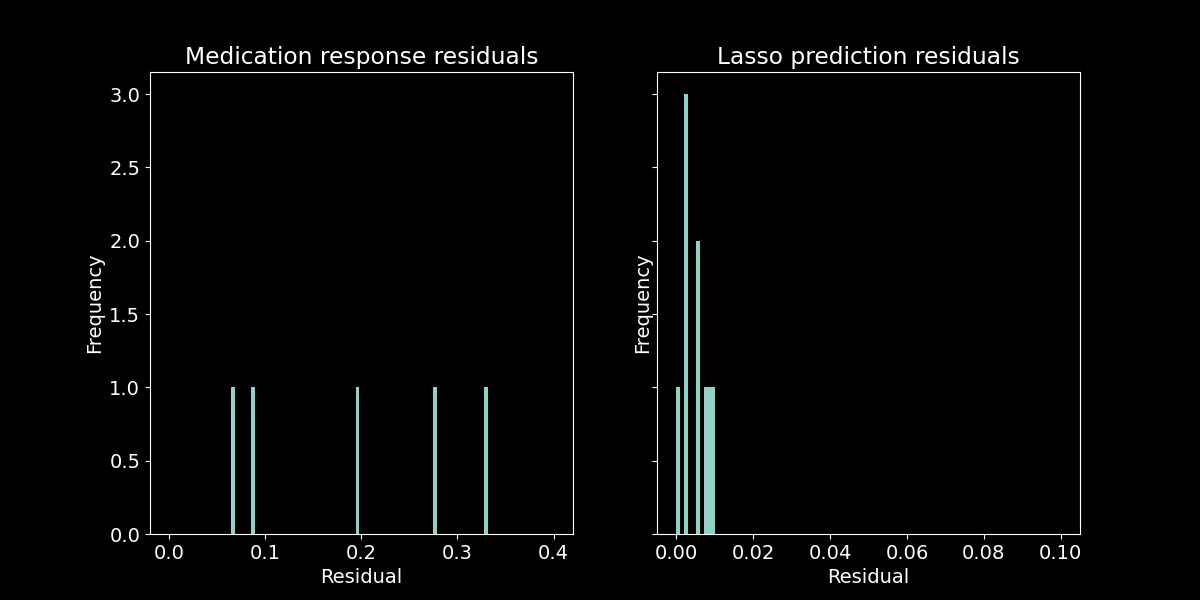

In [38]:
[fig,ax] = plt.subplots(1,2,sharex=False,sharey=True)
ax[0].hist([residual_lct],bins=np.linspace(0,0.4,100))
ax[0].set_title('Medication response residuals')
ax[0].set_xlabel('Residual')
ax[0].set_ylabel('Frequency')
ax[1].hist([residual_ut],bins=np.linspace(0,0.1,100))
ax[1].set_title('Lasso prediction residuals')
ax[1].set_xlabel('Residual')
ax[1].set_ylabel('Frequency')
fig.set_size_inches(12,6)

lbp-2D_firstorder_10Percentile
lbp-3D-k_glcm_Correlation
lbp-3D-k_glcm_Imc1
lbp-3D-k_glszm_SizeZoneNonUniformity
logarithm_glcm_ClusterProminence
squareroot_firstorder_Skewness
squareroot_glrlm_RunVariance
squareroot_glszm_ZoneVariance
wavelet-LLH_gldm_LowGrayLevelEmphasis
wavelet-LHH_glszm_GrayLevelNonUniformity
wavelet-HLL_ngtdm_Busyness
wavelet-HLH_gldm_SmallDependenceLowGrayLevelEmphasis
wavelet-HLH_glszm_LowGrayLevelZoneEmphasis
wavelet-HLH_glszm_SmallAreaLowGrayLevelEmphasis
wavelet-HHL_glcm_ClusterShade


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


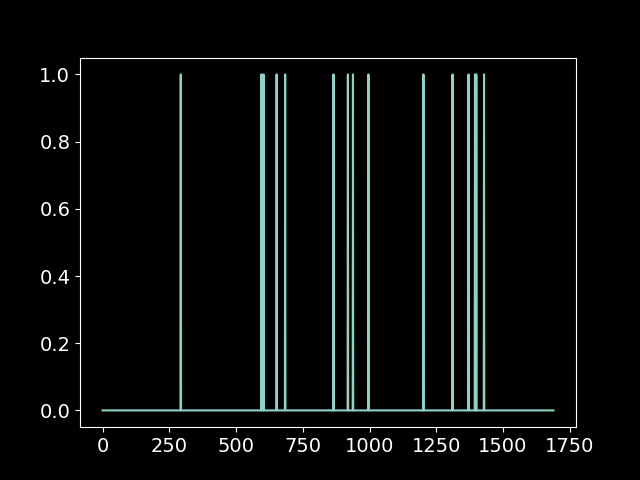

/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


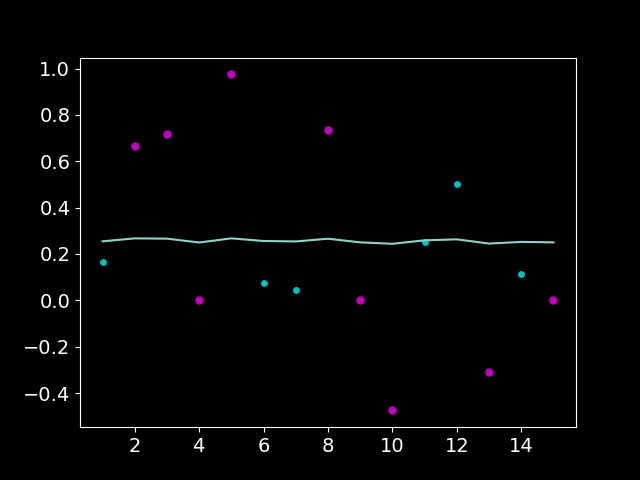

/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove th

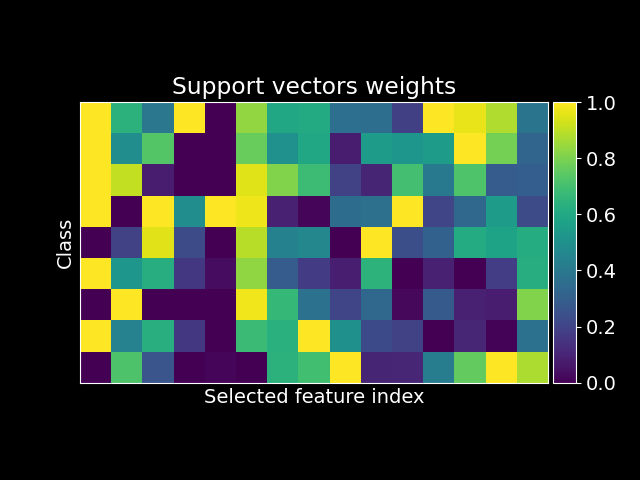

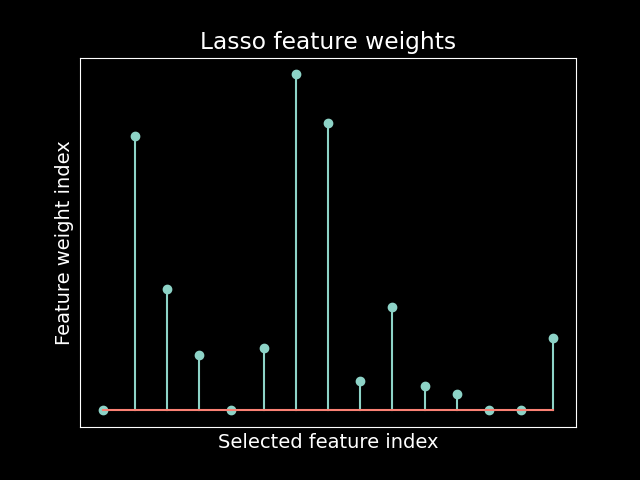

In [39]:
if retrain == 1:
    feats = clf_nsvr.best_estimator_.steps[0][1].get_support()
    with open('lasso_sas_feats.txt','w') as f:
        f.write('Lasso selected features from model trained on '+str(datetime.now())+'\n')
    for k in range(feats.__len__()-1):
        if feats[k] == True:
            with open('lasso_sas_feats.txt','a') as f:
                f.write(keys[k]+'\n')
            print(keys[k])

    fig,ax = plt.subplots(1,1)
    plt.plot(feats)
    plt.show()

    clf_nsvr.best_estimator_.steps[1][1].support_vectors_.shape
    np.array(clf_nsvr.best_estimator_.predict(X_j))

    cases = np.linspace(1,n_cases-1,n_cases-1)
    fig,ax = plt.subplots(1,1)
    sv_ind = clf_nsvr.best_estimator_.steps[1][1].support_
    # Plot remaining data
    plt.scatter(cases,per_change_train_j,label='data',zorder=2,c='c',edgecolors=(0,0,0))
    # Plot support vectors
    plt.scatter(
        cases[sv_ind],
        per_change_train_j[sv_ind],
        s=50,
        c='m',
        label='SVR support vectors',
        zorder=2,
        edgecolors=(0,0,0))


    plt.plot(cases,np.array(clf_nsvr.best_estimator_.predict(X_j))),
    plt.style.use('dark_background')
    plt.show()

    X_SVR = clf_nsvr.best_estimator_.steps[1][1].support_vectors_
    fig,ax = plt.subplots(1,1)
    im_svr = plt.imshow(X_SVR)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Selected feature index')
    plt.ylabel('Class')
    plt.title('Support vectors weights')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right',size='5%',pad=0.05)
    plt.colorbar(im_svr,cax=cax,orientation='vertical')

    X_Lasso = clf_nsvr.best_estimator_.steps[0][1]._transform(X_t)
    fig,ax = plt.subplots(1,1)
    plt.stem(X_Lasso.ravel())
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Selected feature index')
    plt.ylabel('Feature weight index')
    plt.title('Lasso feature weights')
